In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm
import matplotlib.pyplot as pp
import numpy as np

from sigma_graph.envs.figure8.action_lookup import MOVE_LOOKUP, TURN_90_LOOKUP
from sigma_graph.envs.figure8.default_setup import OBS_TOKEN
from sigma_graph.envs.figure8.figure8_squad_rllib import Figure8SquadRLLib
from sigma_graph.envs.figure8.gflow_figure8_squad import GlowFigure8Squad
#from graph_scout.envs.base import ScoutMissionStdRLLib
import sigma_graph.envs.figure8.default_setup as default_setup
import model  # THIS NEEDS TO BE HERE IN ORDER TO RUN __init__.py!
import model.utils as utils
import model.gnn_gflow 
from trajectory import Trajectory
import losses
import torch.optim as optim
import wandb

INPUT_DIMS = 27
OUTPUT_DIMS = 5
NUM_EPOCHS = 100000
TRAJECTORY_LENGTH = 20
BATCH_SIZE = 100
START_NODE = 25
LEARNING_RATE = 3e-4
WANDB = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transitions = {
    1: {0: 1, 1: 2, 2: 1, 3: 3, 4: 1},
    2: {0: 2, 1: 12, 2: 1, 3: 2, 4: 2},
    3: {0: 3, 1: 3, 2: 3, 3: 4, 4: 1},
    4: {0: 4, 1: 5, 2: 4, 3: 6, 4: 3},
    5: {0: 5, 1: 13, 2: 4, 3: 5, 4: 5},
    6: {0: 6, 1: 6, 2: 6, 3: 7, 4: 4},
    7: {0: 7, 1: 8, 2: 7, 3: 9, 4: 6},
    8: {0: 8, 1: 14, 2: 7, 3: 8, 4: 8},
    9: {0: 9, 1: 9, 2: 9, 3: 10, 4: 7},
    10: {0: 10, 1: 11, 2: 10, 3: 10, 4: 9},
    11: {0: 11, 1: 15, 2: 10, 3: 16, 4: 11},
    12: {0: 12, 1: 18, 2: 2, 3: 12, 4: 12},
    13: {0: 13, 1: 19, 2: 5, 3: 13, 4: 13},
    14: {0: 14, 1: 20, 2: 8, 3: 14, 4: 14},
    15: {0: 15, 1: 21, 2: 11, 3: 17, 4: 15},
    16: {0: 16, 1: 17, 2: 16, 3: 16, 4: 11},
    17: {0: 17, 1: 22, 2: 16, 3: 23, 4: 15},
    18: {0: 18, 1: 18, 2: 12, 3: 25, 4: 18},
    19: {0: 19, 1: 19, 2: 13, 3: 26, 4: 25},
    20: {0: 20, 1: 20, 2: 14, 3: 27, 4: 26},
    21: {0: 21, 1: 21, 2: 15, 3: 22, 4: 27},
    22: {0: 22, 1: 22, 2: 17, 3: 24, 4: 21},
    23: {0: 23, 1: 24, 2: 17, 3: 23, 4: 17},
    24: {0: 24, 1: 22, 2: 23, 3: 24, 4: 22},
    25: {0: 25, 1: 25, 2: 25, 3: 19, 4: 18},
    26: {0: 26, 1: 26, 2: 26, 3: 20, 4: 19},
    27: {0: 27, 1: 27, 2: 27, 3: 21, 4: 20}
}

local_action_move = {
    0: "NOOP",
    1: "N",
    2: "S",
    3: "W",
    4: "E",
}

def state_to_vec(state):
    result = [0]*27
    result[state-1] = 1
    return torch.tensor(result).float()

def compute_reward(state):
    if state == 10:
        return 2
    if state == 2:
        return 1
    return 0

def convert_discrete_action_to_multidiscrete(action):
        return [action % len(local_action_move), action // len(local_action_move)]

2024-02-21 16:39:35,017	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.agents.dqn` has been deprecated. Use `ray.rllib.algorithms.[dqn|simple_q|r2d2|apex_dqn]` instead. This will raise an error in the future!


In [2]:
# Investigate loss rewar mirror
# Try real reward
# Make code cleaner 
# visualize flows 

if WANDB:
    wandb.init(
        project="graph-training-simulation",
        config={
            "learning_rate": LEARNING_RATE,
            "epocs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE
        }
    )

config = {
    "custom_model": "fcn",
    "reward": "toy",
    "custom_model_config": {
        "nred": 1,
        "nblue": 1,
        "aggregation_fn": "agent_node",
        "hidden_size": 15,
        "is_hybrid": False,
        "conv_type": "gcn",
        "layernorm": False,
        "graph_obs_token": {"embed_opt": False, "embed_dir": True},
    },
    "env_config": {
        "env_path": ".",
        "act_masked": True,
        "init_red": None,
        "init_blue": None,
        "init_health_red": 20,
        "init_health_blue": 20,
        "obs_embed": False,
        "obs_dir": False,
        "obs_team": True,
        "obs_sight": False,
        "log_on": False,
        "log_path": "logs/temp/",
        "fixed_start": -1,
        "penalty_stay": 0,
        "threshold_damage_2_blue": 2,
        "threshold_damage_2_red": 5,
    },
}
LEARNING_RATE = 3e-4
gflowfigure8 = GlowFigure8Squad(sampler_config=config)
# sampler_fcn -> sampler
# TODO: this is bad revisit and come up with something more concise

optimizer = optim.AdamW(gflowfigure8.sampler.parameters(), lr=LEARNING_RATE)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: r-marr747. Use `wandb login --relogin` to force relogin


---------------
path_data ./GflowsForSimulation/sigma_graph/data/parsed/
/Users/ryanmarr/Documents/CognArch/GflowsForSimulation


In [3]:
# Using sigma code fully

minibatch_loss = 0
minibatch_reward = 0
minibatch_z = 0
minibatch_pf = 0
minibatch_pb = 0

for episode in tqdm.tqdm(range(NUM_EPOCHS), ncols=40):
  
  TEMP_AGENT_INDEX = 0
  gflowfigure8._reset_agents()

  total_P_F = 0
  total_P_B = 0
  for t in range(TRAJECTORY_LENGTH):

    step = gflowfigure8.step(TEMP_AGENT_INDEX)  
    total_P_F += step['forward_prob']
    total_P_B += step['backward_prob']

    if t == TRAJECTORY_LENGTH-1:
      reward_value = gflowfigure8._step_reward_test()
      reward = torch.tensor(reward_value)

  logZ = gflowfigure8.sampler.logZ
 
  reward = torch.log(reward).clip(-20)
  loss = (logZ + total_P_F - reward - total_P_B).pow(2)
  
  minibatch_loss += loss
  minibatch_reward += reward
  minibatch_z += logZ
  minibatch_pf += total_P_F
  minibatch_pb += total_P_B

  if episode % BATCH_SIZE == 0:
    if WANDB:
      wandb.log({
          "loss": minibatch_loss/BATCH_SIZE, 
          "reward":  minibatch_reward/BATCH_SIZE,
          "pf": minibatch_pf/BATCH_SIZE,
          "pb": minibatch_pb/BATCH_SIZE,
          "Z": minibatch_z/BATCH_SIZE
        })
      # for name, param in sampler.named_parameters():
      #     wandb.log({f"{name}_mean": param.data.mean().item(), f"{name}_std": param.data.std().item()})
          
    minibatch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    minibatch_loss = 0
    minibatch_reward = 0
    minibatch_z = 0
    minibatch_pf = 0
    minibatch_pb = 0

  0%|       | 0/1000000 [00:00<?, ?it/s]

  8%| | 77131/1000000 [18:49:22<16:52:33

In [ ]:
class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()

    self.mlp_forward = nn.Sequential(nn.Linear(INPUT_DIMS, num_hid), nn.LeakyReLU(),
                             nn.Linear(num_hid, OUTPUT_DIMS))
    
    self.mlp_backward = nn.Sequential(nn.Linear(INPUT_DIMS, num_hid), nn.LeakyReLU(),
                             nn.Linear(num_hid, OUTPUT_DIMS))
    
    self.logZ = nn.Parameter(torch.ones(1))

  def forward(self, x):
    P_F = self.mlp_forward(x)
    return P_F
  
  def backward(self, x):
    P_B = self.mlp_backward(x) 

    return P_B
  

In [ ]:
# Very basic toy env 

model = TBModel(512)
opt = torch.optim.Adam(model.parameters(),  3e-4)

tb_losses = []
tb_rewards = []
logZs = []

minibatch_loss = 0
minibatch_reward = 0

for episode in tqdm.tqdm(range(NUM_EPOCHS), ncols=40):
  state = START_NODE
  
  total_P_F = 0
  total_P_B = 0
  for t in range(TRAJECTORY_LENGTH):
    P_F_s = model.forward(state_to_vec(state))
    P_B_s = model.backward(state_to_vec(state))

    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    new_state = transitions[state][action.item()]
    total_P_F += cat.log_prob(action)

    if t == TRAJECTORY_LENGTH-1:
      reward_value = compute_reward(new_state)
      reward = torch.tensor(reward_value)

    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    state = new_state


  loss = (model.logZ + total_P_F - torch.log(reward).clip(-20) - total_P_B).pow(2)
  minibatch_loss += loss
  minibatch_reward += reward

  if episode % BATCH_SIZE == 0:
    tb_losses.append(minibatch_loss.item())
    tb_rewards.append(minibatch_reward.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    minibatch_reward = 0
    logZs.append(model.logZ.item())


NameError: name 'TBModel' is not defined

Text(0, 0.5, 'rewards')

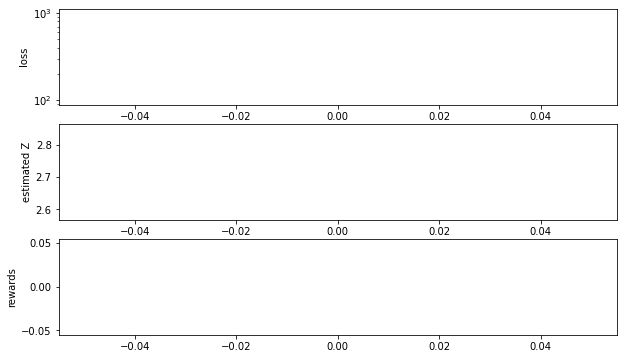

In [ ]:
f, ax = pp.subplots(3, 1, figsize=(10,6))
pp.sca(ax[0])
pp.plot(tb_losses)
pp.yscale('log')
pp.ylabel('loss')
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel('estimated Z')
pp.sca(ax[2])
pp.plot(tb_rewards)
pp.ylabel('rewards')

In [ ]:
# using sampler only not really needed any more

# tb_losses = []
# tb_rewards = []
# logZs = []

# minibatch_loss = 0
# minibatch_reward = 0
  
# for episode in tqdm.tqdm(range(NUM_EPOCHS), ncols=40):
#   state = START_NODE
  
#   total_P_F = 0
#   total_P_B = 0
#   for t in range(TRAJECTORY_LENGTH):

#     f_probs = gflowfigure8.sampler_fcn.forward([state_to_vec(state).to(device)])
#     b_probs = gflowfigure8.sampler_fcn.backward([state_to_vec(state).to(device)])

#     cat = Categorical(logits=f_probs)
#     discrete_action = cat.sample()
#     multidiscrete_action = convert_discrete_action_to_multidiscrete(discrete_action)

#     new_state = transitions[state][multidiscrete_action[0].tolist()]
#     total_P_F += cat.log_prob(discrete_action)

#     if t == TRAJECTORY_LENGTH-1:
#       reward_value = compute_reward(new_state)
#       reward = torch.tensor(reward_value)

#     # same forward action?
#     # TODO investigate difference between selecting backwards action and using forward action on backwards distribution
#     # cat = Categorical(logits=b_probs)
#     # discrete_action = cat.sample()
#     total_P_B += Categorical(logits=b_probs).log_prob(discrete_action)

#     state = new_state

#   logZ = gflowfigure8.sampler_fcn.logZ

#   loss = (logZ + total_P_F - torch.log(reward).clip(-20) - total_P_B).pow(2)
#   minibatch_loss += loss
#   minibatch_reward += reward

#   if episode % BATCH_SIZE == 0:
#     tb_losses.append(minibatch_loss.item())
#     tb_rewards.append(minibatch_reward.item())
#     minibatch_loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     minibatch_loss = 0
#     minibatch_reward = 0
#     logZs.append(gflowfigure8.sampler_fcn.logZ.item())

# f, ax = pp.subplots(3, 1, figsize=(10,6))
# pp.sca(ax[0])
# pp.plot(tb_losses)
# pp.yscale('log')
# pp.ylabel('loss')
# pp.sca(ax[1])
# pp.plot(np.exp(logZs))
# pp.ylabel('estimated Z')
# pp.sca(ax[2])
# pp.plot(tb_rewards)
# pp.ylabel('rewards')

Text(0, 0.5, 'rewards')

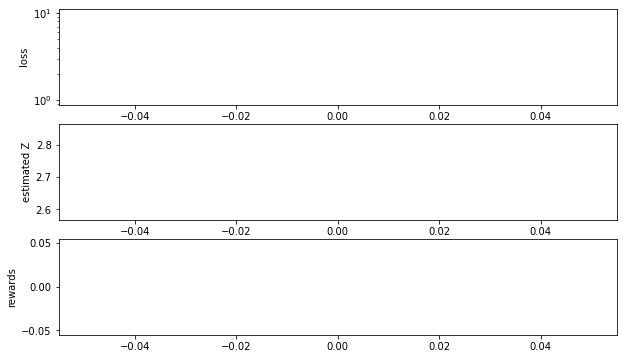

In [ ]:
f, ax = pp.subplots(3, 1, figsize=(10,6))
pp.sca(ax[0])
pp.plot(tb_losses[1:])
pp.yscale('log')
pp.ylabel('loss')
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel('estimated Z')
pp.sca(ax[2])
pp.plot(tb_rewards)
pp.ylabel('rewards')